# Conduct EDA on linked dataset and baseline model results

In [1]:
import pandas as pd
import geopandas as gpd
from shapely import wkt

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.colorbar import ColorbarBase
from matplotlib.cm import ScalarMappable, get_cmap

from pathlib import Path

/home/abbymoreno/miniconda3/envs/lacuna-fund/lib/python3.9/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(


## Load data directory

In [2]:
# linked data
DATA_DIR = Path("../../data/linked_data")

In [3]:
GEOG_HEALTH = DATA_DIR / "geog_health_city_merged.csv"

MODEL_DF = DATA_DIR / "city_merged_w_outbreak_tag.csv"
ANALYZE_DF = DATA_DIR / "analyze_city_merged_w_outbreak_preds.csv"

DAGUPAN_DENGUE = DATA_DIR / "dagupan_dengue_city_merged_w_outbreak_tag.csv"
DAGUPAN_ROTAVIRUS = DATA_DIR / "dagupan_rotavirus_city_merged_w_outbreak_tag.csv"
MUNTI_DENGUE = DATA_DIR / "muntinlupa_dengue_city_merged_w_outbreak_tag.csv"
MUNTI_ROTAVIRUS = DATA_DIR / "muntinlupa_rotavirus_city_merged.csv"

## 1. What are the Top CDs cases /NCDs deaths? One bar graph CD, One bar graph NCD

**Type**: Bar graphs/Pie Charts for Rankings, lists, percentages

### Load city information and health cases

In [ ]:
geog_health_df = pd.read_csv(GEOG_HEALTH)
geog_health_df.head(3)

In [ ]:
geog_health_df["date"] = pd.to_datetime(geog_health_df["date"])

In [ ]:
geog_health_df = geog_health_df[geog_health_df["date"].dt.year >= 2020]

In [ ]:
AREA_DATE_COLS = [
    "adm3_en",
    "adm3_pcode",
    "date",
    "year",
    "week",
    "brgy_distance_to_coast",
    "brgy_is_coastal",
]
CASE_COLS = geog_health_df.columns[
    geog_health_df.columns.str.startswith("case")
].tolist()
DEATH_COLS = geog_health_df.columns[
    geog_health_df.columns.str.startswith("death")
].tolist()

### Disease utils

In [ ]:
def plot_diseases_bar(df, cols_list=CASE_COLS, category="CD", city=""):
    count_df = df[cols_list].sum().sort_values(ascending=True)
    count_df.plot(kind="barh")

    if city == "":
        # Set the title and labels
        plt.title(f"Total historical sum of {category}s")
        plt.xlabel("Diseases")
        plt.ylabel("Sum of Cases")

        plt.show()
    else:
        # Set the title and labels
        plt.title(f"Total historical sum of {category}s - {city}")
        plt.xlabel("Diseases")
        plt.ylabel("Sum of Cases")

        plt.show()

### Historical plot of CDs 

In [ ]:
# historically from 2003 to 2022
plot_diseases_bar(geog_health_df, cols_list=CASE_COLS, category="CD")

### Historical Plot of NCDs

In [ ]:
# historically from 2003 to 2022
plot_diseases_bar(geog_health_df, cols_list=DEATH_COLS, category="NCD")

### Check all historical CDs and NCDs across the 12 cities

In [ ]:
city_names = geog_health_df["adm3_en"].unique().tolist()
print(city_names)

In [ ]:
CASE_COLS

In [ ]:
for city in city_names:
    print(f"Plot overall diseases count for {city}")
    city_df = geog_health_df[geog_health_df["adm3_en"] == city]
    # city_df = city_df.drop(columns=['case_total_dengue'])
    plot_diseases_bar(city_df, cols_list=CASE_COLS, category="CD", city=city)
    plot_diseases_bar(city_df, cols_list=DEATH_COLS, category="NCD", city=city)

In [ ]:
geog_health_df.groupby("adm3_en")[CASE_COLS].sum()

In [ ]:
geog_health_df.groupby("adm3_en")[DEATH_COLS].sum()

### Year on year growth

## 2. What diseases are coastal communities most susceptible to?

> Removing this question as there are no unique diseases to the communities.

In [ ]:
geog_health_df["brgy_distance_to_coast"].describe()

In [ ]:
# coastal brgy
coastal_areas = geog_health_df[geog_health_df["brgy_distance_to_coast"] <= 1631]
coastal_areas["adm3_en"].unique()

Plot seems to be the same as the overall diseases.

> Can omit this plot

In [ ]:
coastal_cd_sum = coastal_areas[CASE_COLS].sum().sort_values(ascending=False)
coastal_cd_sum.plot(kind="bar")

# Set the title and labels
plt.title("Total historical sum of CDs")
plt.xlabel("Diseases")
plt.ylabel("Sum of Cases")

## Prepare barangay tables with geometries

In [4]:
# open barangay geometries
brgy_df = pd.read_csv(DATA_DIR / "tables/brgy_geography.csv")
brgy_df = brgy_df.drop(
    columns=["Unnamed: 0", "freq", "date", "uuid", "brgy_total_area"]
)
brgy_df["geometry"] = brgy_df["geometry"].apply(wkt.loads)

brgy_gdf = gpd.GeoDataFrame(brgy_df, geometry="geometry")
brgy_gdf.head(3)

,adm4_pcode,brgy_distance_to_coast,brgy_is_coastal,geometry
0,PH050506053,990.730626,False,"POLYGON ((123.73599 13.18949, 123.74029 13.185..."
1,PH050506056,0.000000,True,"POLYGON ((123.75832 13.09303, 123.75834 13.092..."
2,PH050506072,2560.801915,False,"POLYGON ((123.73403 13.13871, 123.73406 13.138..."


In [5]:
# open full admin boundary table
loc_df = pd.read_csv(DATA_DIR / "tables/location.csv")
loc_df = loc_df.drop(columns=["Unnamed: 0", "uuid"])
loc_df.head(3)

,adm1_en,adm1_pcode,adm2_en,adm2_pcode,adm3_en,adm3_pcode,adm4_en,adm4_pcode,brgy_total_area
0,Region I,PH010000000,Pangasinan,PH015500000,Dagupan City,PH015518000,Lomboy,PH015518016,1.0216
1,Region I,PH010000000,Pangasinan,PH015500000,Dagupan City,PH015518000,Tapuac,PH015518031,1.0440
2,Region I,PH010000000,Pangasinan,PH015500000,Dagupan City,PH015518000,Pantal,PH015518022,3.2625


In [6]:
# merge location and geometry tables
brgy_gdf = loc_df.merge(brgy_gdf, how="left", on="adm4_pcode")
brgy_gdf = gpd.GeoDataFrame(brgy_gdf)
brgy_gdf.head(2)

,adm1_en,adm1_pcode,adm2_en,adm2_pcode,adm3_en,adm3_pcode,adm4_en,adm4_pcode,brgy_total_area,brgy_distance_to_coast,brgy_is_coastal,geometry
0,Region I,PH010000000,Pangasinan,PH015500000,Dagupan City,PH015518000,Lomboy,PH015518016,1.0216,308.382889,False,"POLYGON ((120.32742 16.05423, 120.32719 16.053..."
1,Region I,PH010000000,Pangasinan,PH015500000,Dagupan City,PH015518000,Tapuac,PH015518031,1.0440,2595.485717,False,"POLYGON ((120.33380 16.03974, 120.33389 16.039..."


# What other variables contribute to the cases?

-  Population, and other environment variables (hazard, land use, built up areas)
-  Plot isochrones, access to healthcare facilities (choropleth)
-  Plot wealth index


## Utils

In [17]:
def plot_choropleth_all_cities(
    feat_df, feat_col, vmin, vmax, cmap="Reds", label="Population Density"
):
    # Ensure the data is grouped by the 'city' column
    # max_val = pop_df[pop_col].max()
    grouped = feat_df.groupby("adm3_en")

    # Number of cities
    num_cities = len(grouped)

    # Create subplots - adjust the number of rows and columns as needed
    fig, axs = plt.subplots(
        nrows=int(num_cities**0.5) + 1,
        ncols=int(num_cities**0.5) + 1,
        figsize=(15, 18),
    )
    axs = axs.flatten()  # Flatten the array of axes

    # Define colormap and normalization
    cmap = get_cmap(cmap)
    # norm = Normalize(vmin=pop_df[pop_col].min().min(), vmax=pop_df[pop_col].max())

    # Loop through each city and plot it
    for i, (city_name, data) in enumerate(grouped):
        ax = axs[i]
        data.plot(
            ax=ax,
            legend=True,
            column=feat_col,
            cmap=cmap,
            legend_kwds={
                "label": label,
                "orientation": "horizontal",
                "shrink": 0.8,
                "anchor": (0.5, 1),
            },
            vmin=vmin,
            vmax=vmax
            # vmax=pop_df[pop_col].describe(percentiles=[0.75, 0.9, 0.95])['95%']
        )  # Plot the data
        ax.set_title(f"{city_name}")
        ax.axis("off")  # Turn off axis

    # Hide any unused axes if there are any
    for j in range(i + 1, len(axs)):
        axs[j].set_visible(False)

    # Create a color bar at the bottom of the plots
    # cax = fig.add_axes([0.1, 0.08, 0.8, 0.03])  # Position for the color bar [left, bottom, width, height]
    # sm = ScalarMappable(norm=norm, cmap=cmap)
    # sm._A = []  # This is necessary for ScalarMappable
    # cb = ColorbarBase(cax, cmap=cmap, norm=norm, orientation='horizontal')
    # cb.set_label('Data Scale')  # You can customize this label

    plt.tight_layout()  # Adjust the rect to leave space for the color bar
    # Show the plot
    plt.show()

# 4. How is each city's access to healthcare facilities relative to their area?

## % reached in health facilities

In [7]:
# open health access files
brgy_iso = pd.read_csv(DATA_DIR / "tables/mapbox_health_facility_brgy_isochrones.csv")
brgy_iso = brgy_iso.drop(columns=["Unnamed: 0", "uuid", "date", "freq"])
brgy_iso.head(3)

,adm4_pcode,brgy_healthcenter_pop_reached_5min,brgy_healthcenter_pop_reached_15min,brgy_healthcenter_pop_reached_30min,brgy_healthcenter_pop_reached_pct_5min,brgy_healthcenter_pop_reached_pct_15min,brgy_healthcenter_pop_reached_pct_30min,hospital_pop_reached_5min,hospital_pop_reached_15min,hospital_pop_reached_30min,hospital_pop_reached_pct_5min,hospital_pop_reached_pct_15min,hospital_pop_reached_pct_30min,rhu_pop_reached_5min,rhu_pop_reached_15min,rhu_pop_reached_30min,rhu_pop_reached_pct_5min,rhu_pop_reached_pct_15min,rhu_pop_reached_pct_30min
0,PH015518001,1210.18,5829.71,5829.71,20.76,100.00,100.00,5195.69,5829.71,5829.71,89.12,100.00,100.00,418.16,5829.71,5829.71,7.17,100.00,100.00
1,PH015518002,2697.99,2697.99,2697.99,100.00,100.00,100.00,359.87,2697.99,2697.99,13.34,100.00,100.00,0.00,2697.99,2697.99,0.00,100.00,100.00
2,PH015518003,921.44,921.44,921.44,61.54,61.54,61.54,921.44,921.44,921.44,61.54,61.54,61.54,921.44,921.44,921.44,61.54,61.54,61.54


In [8]:
# keep only necessary cols
pct_cols = [col for col in brgy_iso.columns if col.__contains__("_pct")]
brgy_iso = brgy_iso[["adm4_pcode"] + pct_cols]
brgy_iso.head(3)

,adm4_pcode,brgy_healthcenter_pop_reached_pct_5min,brgy_healthcenter_pop_reached_pct_15min,brgy_healthcenter_pop_reached_pct_30min,hospital_pop_reached_pct_5min,hospital_pop_reached_pct_15min,hospital_pop_reached_pct_30min,rhu_pop_reached_pct_5min,rhu_pop_reached_pct_15min,rhu_pop_reached_pct_30min
0,PH015518001,20.76,100.00,100.00,89.12,100.00,100.00,7.17,100.00,100.00
1,PH015518002,100.00,100.00,100.00,13.34,100.00,100.00,0.00,100.00,100.00
2,PH015518003,61.54,61.54,61.54,61.54,61.54,61.54,61.54,61.54,61.54


In [9]:
brgy_iso = brgy_iso.merge(
    brgy_gdf[["adm3_en", "adm4_pcode", "geometry"]], on="adm4_pcode", how="left"
)

In [10]:
brgy_iso = gpd.GeoDataFrame(brgy_iso)

In [14]:
health_facility_type = ["brgy_healthcenter", "hospital", "rhu"]
pct_5min = [col for col in brgy_iso.columns if col.endswith("_5min")]
pct_15min = [col for col in brgy_iso.columns if col.endswith("_15min")]
pct_30min = [col for col in brgy_iso.columns if col.endswith("_30min")]

In [15]:
cities = brgy_gdf["adm3_en"].unique().tolist()
print(cities)

['Dagupan City', 'Palayan City', 'Legazpi City', 'Iloilo City', 'Mandaue City', 'Tacloban City', 'Zamboanga City', 'Cagayan de Oro City', 'Davao City', 'City of Mandaluyong', 'City of Navotas', 'City of Muntinlupa']


In [ ]:
def plot_health_access(iso_gdf, city, pct_cols):
    fig, axs = plt.subplots(1, 3, figsize=(14, 6))
    # Define the number of rows and columns for subplots

    city_data = iso_gdf[iso_gdf["adm3_en"] == city]

    # Define colormap and normalization
    cmap = get_cmap("YlGnBu")
    norm = Normalize(
        vmin=city_data[pct_cols].min().min(), vmax=city_data[pct_cols].max().max()
    )

    # Iterate over the columns and plot each one
    for ax, column in zip(axs, pct_cols):
        city_data.plot(column=column, ax=ax, legend=False, cmap=cmap, norm=norm)
        ax.set_title(f"{column}")
        ax.axis("off")  # Turn off the axis

    # Create a color bar at the bottom of the plots
    cax = fig.add_axes(
        [0.1, 0.08, 0.8, 0.03]
    )  # Position for the color bar [left, bottom, width, height]
    sm = ScalarMappable(norm=norm, cmap=cmap)
    sm._A = []  # This is necessary for ScalarMappable
    cb = ColorbarBase(cax, cmap=cmap, norm=norm, orientation="horizontal")
    cb.set_label("Data Scale")  # You can customize this label

    plt.tight_layout(
        rect=[0, 0.15, 1, 1]
    )  # Adjust the rect to leave space for the color bar
    plt.title(city)
    plt.show()

In [ ]:
for city in cities:
    plot_health_access(brgy_iso, city=city, pct_cols=pct_5min)

/tmp/ipykernel_22315/1369139545.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap(cmap)


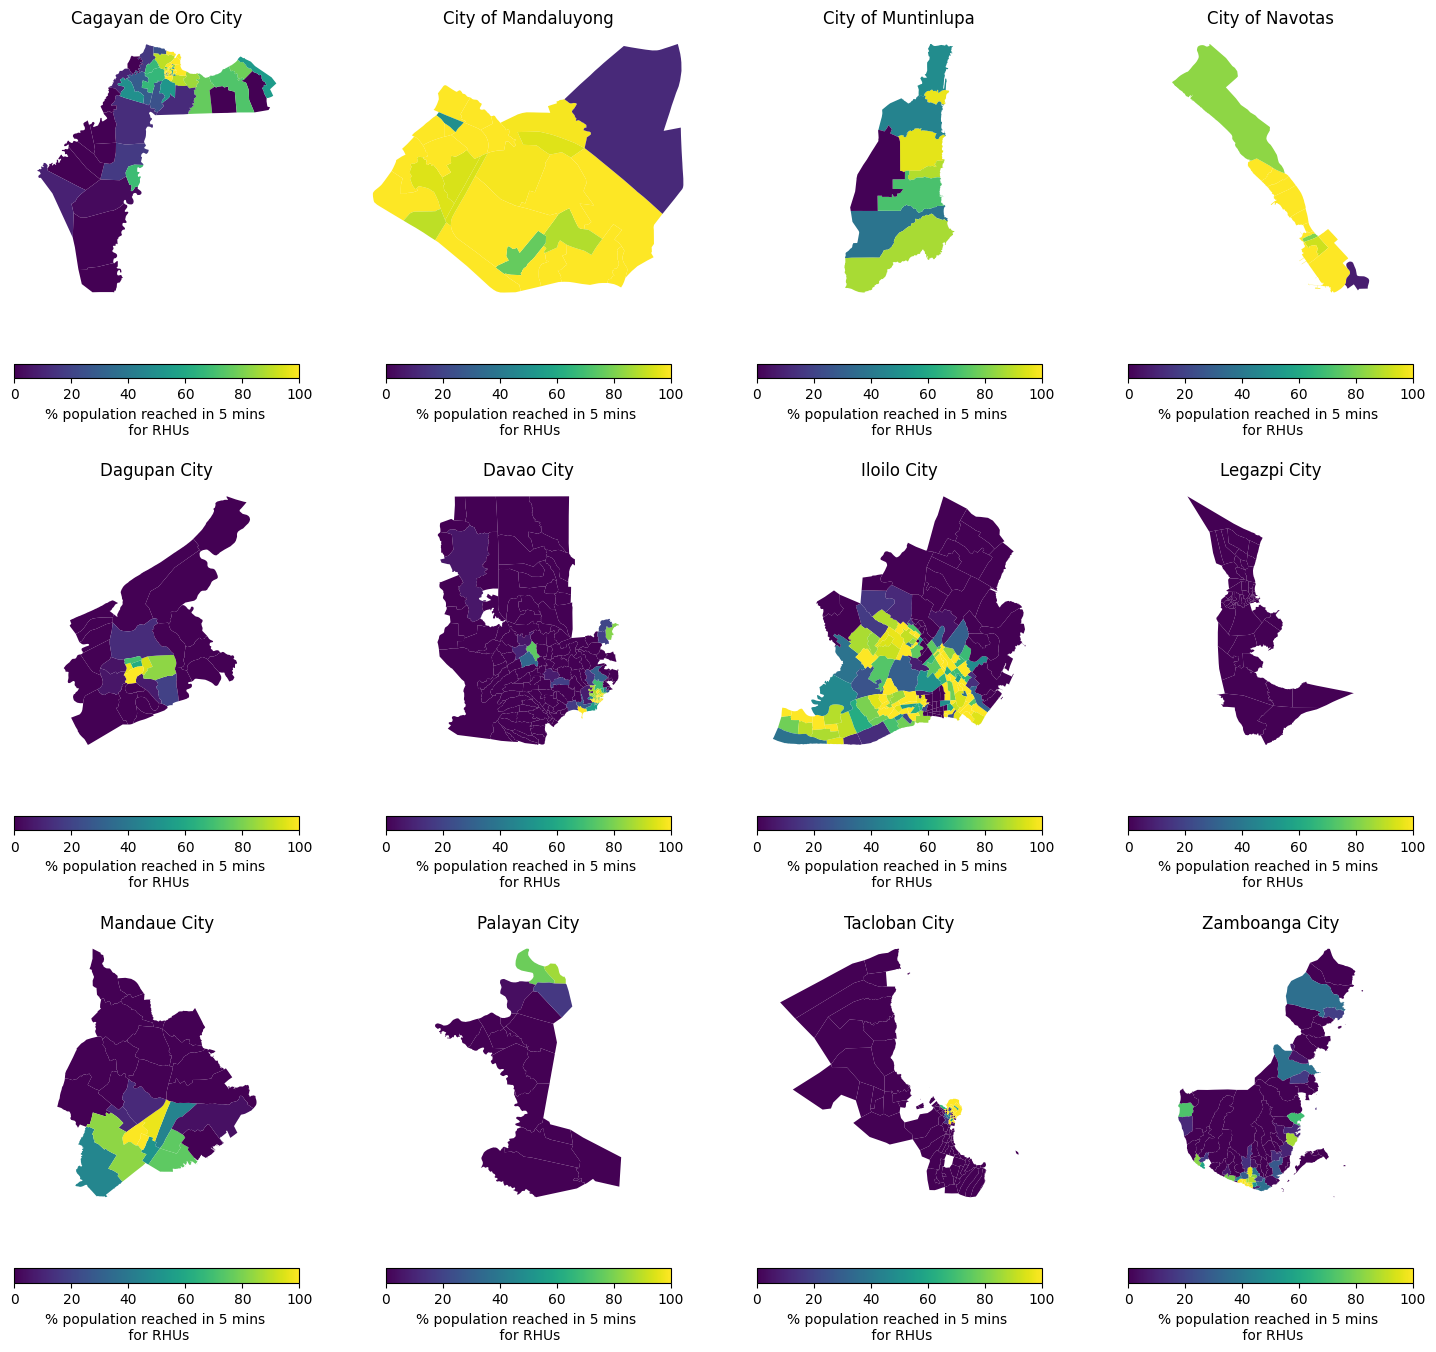

In [25]:
plot_choropleth_all_cities(
    brgy_iso,
    "rhu_pop_reached_pct_5min",
    vmin=0,
    vmax=100,
    cmap="viridis",
    label="% population reached in 5 mins \n for RHUs",
)

## Population Density

In [18]:
population_df = pd.read_csv(DATA_DIR / "tables/worldpop_population.csv")
population_df = population_df.drop(columns=["Unnamed: 0", "uuid"])
population_df = population_df[
    ["adm4_pcode", "date", "pop_count_total", "pop_count_mean"]
]
population_df.head()

,adm4_pcode,date,pop_count_total,pop_count_mean
0,PH137503007,2000-01-01,3350.263672,558.377279
1,PH063022152,2000-01-01,1492.030518,14.346447
2,PH063022015,2000-01-01,688.092651,45.872843
3,PH063022118,2000-01-01,1734.744507,133.441885
4,PH050506019,2000-01-01,268.516998,29.835222


In [19]:
population_df["date"] = pd.to_datetime(population_df["date"])
population_df = population_df[population_df["date"].dt.year == 2020]
population_df = population_df.merge(
    brgy_gdf[["adm3_en", "adm4_pcode", "geometry"]], on="adm4_pcode", how="left"
)
population_gdf = gpd.GeoDataFrame(population_df)
population_gdf

,adm4_pcode,date,pop_count_total,pop_count_mean,adm3_en,geometry
0,PH050506037,2020-01-01,3197.954102,55.137140,Legazpi City,"POLYGON ((123.75574 13.16079, 123.75620 13.160..."
1,PH050506019,2020-01-01,354.687927,39.409770,Legazpi City,"POLYGON ((123.75314 13.14043, 123.75427 13.140..."
2,PH063022118,2020-01-01,1997.376953,153.644381,Iloilo City,"POLYGON ((122.55423 10.68953, 122.55399 10.689..."
3,PH063022015,2020-01-01,785.250183,52.350012,Iloilo City,"POLYGON ((122.56645 10.70953, 122.56652 10.709..."
4,PH063022110,2020-01-01,9717.523438,323.917448,Iloilo City,"POLYGON ((122.54894 10.69108, 122.54910 10.690..."
...,...,...,...,...,...,...
874,PH137401002,2020-01-01,7084.418457,393.578803,City of Mandaluyong,"POLYGON ((121.03209 14.59330, 121.03209 14.593..."
875,PH137401006,2020-01-01,3433.493164,171.674658,City of Mandaluyong,"POLYGON ((121.04319 14.57431, 121.04389 14.573..."
876,PH112402158,2020-01-01,919.029236,153.171539,Davao City,"POLYGON ((125.62109 7.07110, 125.62102 7.07104..."
877,PH015518030,2020-01-01,2914.778076,37.368950,Dagupan City,"POLYGON ((120.35203 16.05978, 120.35206 16.059..."


In [ ]:
plot_choropleth_all_cities(population_gdf, "pop_count_mean", vmin=0, vmax=None)

## Plot Wealth Index

In [ ]:
rwi_df = pd.read_csv(DATA_DIR / "tables/tm_relative_wealth_index.csv")
rwi_df = rwi_df.drop(columns=["Unnamed: 0", "uuid", "date", "freq"])
# hazards_df = hazards_df[['adm4_pcode', 'date', 'pop_count_total', 'pop_count_mean']]
rwi_df.head()

In [ ]:
rwi_df = rwi_df.merge(
    brgy_gdf[["adm3_en", "adm4_pcode", "geometry"]], on="adm4_pcode", how="left"
)
rwi_gdf = gpd.GeoDataFrame(rwi_df)

In [ ]:
plot_pop_density(rwi_gdf, "rwi_mean", vmin=0, vmax=1, cmap="viridis", label="RWI")

## Plot health care facilities

In [ ]:
doh_poi_health = pd.read_csv(DATA_DIR / "tables/geoportal_doh_poi_health.csv")
doh_poi_health = doh_poi_health.drop(columns=["Unnamed: 0", "uuid"])
doh_poi_health.head(2)

In [ ]:
doh_poi_health = doh_poi_health[
    doh_poi_health["adm4_pcode"].isin(dagupan_brgys_list + munti_brgys_list)
]
doh_poi_health = doh_poi_health.merge(
    loc_df[["adm3_en", "adm4_pcode"]], how="left", on="adm4_pcode"
)
doh_poi_health = doh_poi_health.merge(
    brgy_gdf[["adm4_pcode", "geometry"]], how="left", on="adm4_pcode"
)
doh_poi_health.head(2)

In [ ]:
doh_poi_gdf = gpd.GeoDataFrame(doh_poi_health)
dagupan_doh_gdf = doh_poi_gdf[doh_poi_gdf["adm3_en"] == "Dagupan City"]
munti_doh_gdf = doh_poi_gdf[doh_poi_gdf["adm3_en"] == "City of Muntinlupa"]

In [ ]:
ax = dagupan_doh_gdf.plot(column="doh_pois_count", legend=True, cmap="OrRd", vmax=8)
ax.set_title("Dagupan Health POIs")
plt.show()

In [ ]:
ax = munti_doh_gdf.plot(column="doh_pois_count", legend=True, cmap="OrRd")
ax.set_title("Muntinlupa Health POIs")
plt.show()